In [1]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil

2023-02-16 20:36:04.502889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

In [2]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        with open(f'{folder_name}/img_{count}.png', 'wb') as f:
            f.write(image)
        count += 1
        
        # A times.sleep(x) is recommended to avoid latency errors

We can now call this function and store the images locally

```python
fetch_images(k=10_000, folder_name='images')
```

## Validating image
We should validate wether the image exists

In [3]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = io.imread(f'{folder_name}/img_0.png')
        return (True, image)
    except:
        print(f'Image "img_0.png" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [4]:
def show_batch(batch):
    images = np.random.randint(low=0, high=len(batch), size=16) # get random indices
    fig = plt.figure(figsize= (4, 4)) 
    fig, axs = plt.subplots(4,4, sharex=True, sharey=True)
    cnt = 0 
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

In [5]:
def img_attr(batch):
    print(f'Images are {batch[0].shape[0]} by {batch[0].shape[1]} with {batch[0].shape[2]} channels')

---

Retreive all images from dataset

In [6]:
collection = imread_collection("./images/*.png")

In [7]:
len(collection)

10000

<Figure size 288x288 with 0 Axes>

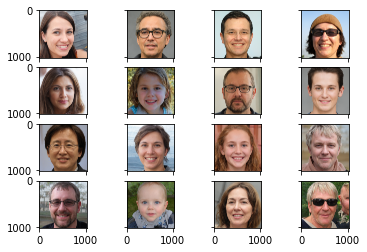

In [8]:
show_batch(collection)

In [9]:
collection[0].shape

(1024, 1024, 3)

In [10]:
img_attr(collection)

Images are 1024 by 1024 with 3 channels


### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels

In [11]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [12]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

We first import libraries to be used

In [210]:
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [211]:
z_dim = 100 # 100 is a good default

We implement the schematics for $G(z)$ to generate $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks) 

In [216]:
def create_generator(output_shape, z):
    model = Sequential()
    model.add(Dense(1024*4*4, input_dim=z))
    model.add(Reshape((4, 4, 1024)))
    model.add(Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(Conv2DTranspose(3, kernel_size=512, strides=32, padding='same'))
    model.add(Activation('tanh'))
    return model

In [217]:
gen = create_generator(image_shape, z_dim)

In [218]:
gen.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 16384)             1654784   
                                                                 
 reshape_62 (Reshape)        (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_169 (Conv2  (None, 8, 8, 512)        8389120   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_170 (Conv2  (None, 16, 16, 256)      2097408   
 DTranspose)                                                     
                                                                 
 conv2d_transpose_171 (Conv2  (None, 32, 32, 128)      524416    
 DTranspose)                                                     
                                                     

In [220]:
noise = tf.random.normal([1, 100])
fake_image = gen(noise, training=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


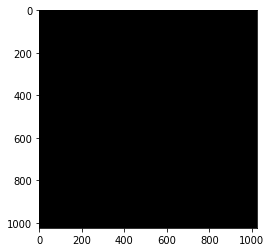

In [221]:
plt.imshow(fake_image[0, :, :, :])